# DDIM vs WGAN: Exploratory Data Analysis

## Comparing Generative Models on Flowers102 and MNIST Datasets

This notebook analyzes and compares the performance of **DDIM (Denoising Diffusion Implicit Models)** and **WGAN (Wasserstein GAN)** across two different datasets:
- **Oxford Flowers102**: 102 flower categories with complex, colorful images
- **MNIST**: Handwritten digits (simpler, grayscale images)

### Key Metrics Analyzed:
- **KID (Kernel Inception Distance)**: Lower is better - measures image quality
- **Training Time**: Time per epoch
- **Sampling Time**: Time to generate images


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set style for beautiful visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Configure plot aesthetics
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

print("Libraries loaded successfully!")


Libraries loaded successfully!


## 1. Load and Preprocess Data


In [2]:
# Load all datasets
data_dir = Path("data")

# Load DDIM data
ddim_flowers_raw = pd.read_csv(data_dir / "ddim_flowers_metrics.csv")
ddim_mnist_raw = pd.read_csv(data_dir / "ddim_mnist_metrics.csv")

# Load WGAN data
wgan_flowers_raw = pd.read_csv(data_dir / "wgan_flowers_metrics.csv")
wgan_mnist_raw = pd.read_csv(data_dir / "wgan_mnist_metrics.csv")

print("Data files loaded:")
print(f"  - DDIM Flowers: {len(ddim_flowers_raw)} rows")
print(f"  - DDIM MNIST: {len(ddim_mnist_raw)} rows")
print(f"  - WGAN Flowers: {len(wgan_flowers_raw)} rows")
print(f"  - WGAN MNIST: {len(wgan_mnist_raw)} rows")


Data files loaded:
  - DDIM Flowers: 358 rows
  - DDIM MNIST: 50 rows
  - WGAN Flowers: 50 rows
  - WGAN MNIST: 50 rows


In [9]:
# Standardize column names and create clean dataframes
# DDIM data uses: epoch, epoch_time, sampling_time, val_kid
# WGAN data uses: Epoch, KID, Training_Time_Sec/Training_Time, Sampling_Time_Sec/Sampling_Time

def standardize_ddim(df, dataset_name):
    """Standardize DDIM dataframe columns"""
    # Handle different column names (sampling vs sampling_time)
    sampling_col = 'sampling_time' if 'sampling_time' in df.columns else 'sampling'
    
    # Keep only relevant columns and first 50 rows (training data)
    clean_df = df[['epoch', 'epoch_time', sampling_col, 'val_kid']].head(50).copy()
    clean_df.columns = ['epoch', 'training_time', 'sampling_time', 'kid']
    
    # Convert all columns to numeric (handles string data issues)
    clean_df['epoch'] = pd.to_numeric(clean_df['epoch'], errors='coerce')
    clean_df['training_time'] = pd.to_numeric(clean_df['training_time'], errors='coerce')
    clean_df['sampling_time'] = pd.to_numeric(clean_df['sampling_time'], errors='coerce')
    clean_df['kid'] = pd.to_numeric(clean_df['kid'], errors='coerce')
    
    # Drop any rows with NaN values (from conversion errors)
    clean_df = clean_df.dropna()
    
    clean_df['epoch'] = clean_df['epoch'] + 1  # Convert 0-indexed to 1-indexed
    clean_df['model'] = 'DDIM'
    clean_df['dataset'] = dataset_name
    return clean_df

def standardize_wgan(df, dataset_name):
    """Standardize WGAN dataframe columns"""
    clean_df = df.copy()
    # Normalize column names (handle different naming conventions)
    clean_df.columns = clean_df.columns.str.lower().str.replace('_sec', '').str.replace('_', ' ')
    clean_df = clean_df.rename(columns={
        'training time': 'training_time',
        'sampling time': 'sampling_time'
    })
    clean_df = clean_df[['epoch', 'kid', 'training_time', 'sampling_time']].copy()
    
    # Convert all columns to numeric
    clean_df['epoch'] = pd.to_numeric(clean_df['epoch'], errors='coerce')
    clean_df['kid'] = pd.to_numeric(clean_df['kid'], errors='coerce')
    clean_df['training_time'] = pd.to_numeric(clean_df['training_time'], errors='coerce')
    clean_df['sampling_time'] = pd.to_numeric(clean_df['sampling_time'], errors='coerce')
    
    # Drop any rows with NaN values
    clean_df = clean_df.dropna()
    
    clean_df['model'] = 'WGAN'
    clean_df['dataset'] = dataset_name
    return clean_df

# Create standardized dataframes
ddim_flowers = standardize_ddim(ddim_flowers_raw, 'Flowers102')
ddim_mnist = standardize_ddim(ddim_mnist_raw, 'MNIST')
wgan_flowers = standardize_wgan(wgan_flowers_raw, 'Flowers102')
wgan_mnist = standardize_wgan(wgan_mnist_raw, 'MNIST')

# Combine all data into one master dataframe
all_data = pd.concat([ddim_flowers, ddim_mnist, wgan_flowers, wgan_mnist], ignore_index=True)

print("Standardized data sample:")
print(all_data.head(10))
print(f"\nTotal records: {len(all_data)}")


Standardized data sample:
   epoch  training_time  sampling_time       kid model     dataset
0      1     111.222537       2.215010  0.545885  DDIM  Flowers102
1      2      43.767640       2.186949  0.549467  DDIM  Flowers102
2      3      43.827313       2.231452  0.548270  DDIM  Flowers102
3      4      44.976223       2.196438  0.512232  DDIM  Flowers102
4      5      45.023357       2.209701  0.478733  DDIM  Flowers102
5      6      44.937134       2.202125  0.474414  DDIM  Flowers102
6      7      44.924638       2.196970  0.339046  DDIM  Flowers102
7      8      44.967196       2.188110  0.235594  DDIM  Flowers102
8      9      46.038071       2.218176  0.169603  DDIM  Flowers102
9     10      45.313262       2.215234  0.113953  DDIM  Flowers102

Total records: 200


## 2. Summary Statistics


In [10]:
# Calculate summary statistics for each model-dataset combination
summary_stats = all_data.groupby(['model', 'dataset']).agg({
    'kid': ['min', 'max', 'mean', 'std'],
    'training_time': ['min', 'max', 'mean', 'sum'],
    'sampling_time': ['min', 'max', 'mean', 'sum']
}).round(4)

# Flatten column names
summary_stats.columns = ['_'.join(col).strip() for col in summary_stats.columns.values]

print("=" * 80)
print("SUMMARY STATISTICS BY MODEL AND DATASET")
print("=" * 80)
print(summary_stats.to_string())
print("=" * 80)


SUMMARY STATISTICS BY MODEL AND DATASET
                  kid_min  kid_max  kid_mean  kid_std  training_time_min  training_time_max  training_time_mean  training_time_sum  sampling_time_min  sampling_time_max  sampling_time_mean  sampling_time_sum
model dataset                                                                                                                                                                                                  
DDIM  Flowers102   0.0495   0.5495    0.1222   0.1564            43.5983           111.2225             45.7583          2287.9145             2.1487             2.2315              2.1917           109.5874
      MNIST        0.0162   0.5908    0.0603   0.1269            65.2771           132.9138             67.4514          3372.5689             2.1679             2.2217              2.1907           109.5340
WGAN  Flowers102   0.1173   0.5079    0.2107   0.0810            61.0651            72.6958             61.7105          3085.52

In [11]:
# Create a clean comparison table
comparison_data = []

for dataset in ['Flowers102', 'MNIST']:
    for model in ['DDIM', 'WGAN']:
        subset = all_data[(all_data['model'] == model) & (all_data['dataset'] == dataset)]
        comparison_data.append({
            'Dataset': dataset,
            'Model': model,
            'Best KID': subset['kid'].min(),
            'Final KID (Epoch 50)': subset[subset['epoch'] == 50]['kid'].values[0] if len(subset[subset['epoch'] == 50]) > 0 else subset['kid'].iloc[-1],
            'Avg Training Time (s)': subset['training_time'].mean(),
            'Total Training Time (min)': subset['training_time'].sum() / 60,
            'Avg Sampling Time (s)': subset['sampling_time'].mean(),
        })

comparison_df = pd.DataFrame(comparison_data)
print("\n📊 MODEL COMPARISON TABLE")
print("=" * 100)
print(comparison_df.to_string(index=False))
print("=" * 100)



📊 MODEL COMPARISON TABLE
   Dataset Model  Best KID  Final KID (Epoch 50)  Avg Training Time (s)  Total Training Time (min)  Avg Sampling Time (s)
Flowers102  DDIM  0.049474              0.050693              45.758289                  38.131908               2.191748
Flowers102  WGAN  0.117318              0.118487              61.710495                  51.425413               0.350389
     MNIST  DDIM  0.016218              0.017346              67.451379                  56.209482               2.190680
     MNIST  WGAN  0.012068              0.014087             574.634400                 478.862000               0.317600


## 3. KID Score Analysis

**KID (Kernel Inception Distance)** measures the quality of generated images compared to real images. Lower KID values indicate better image quality and more realistic generations.


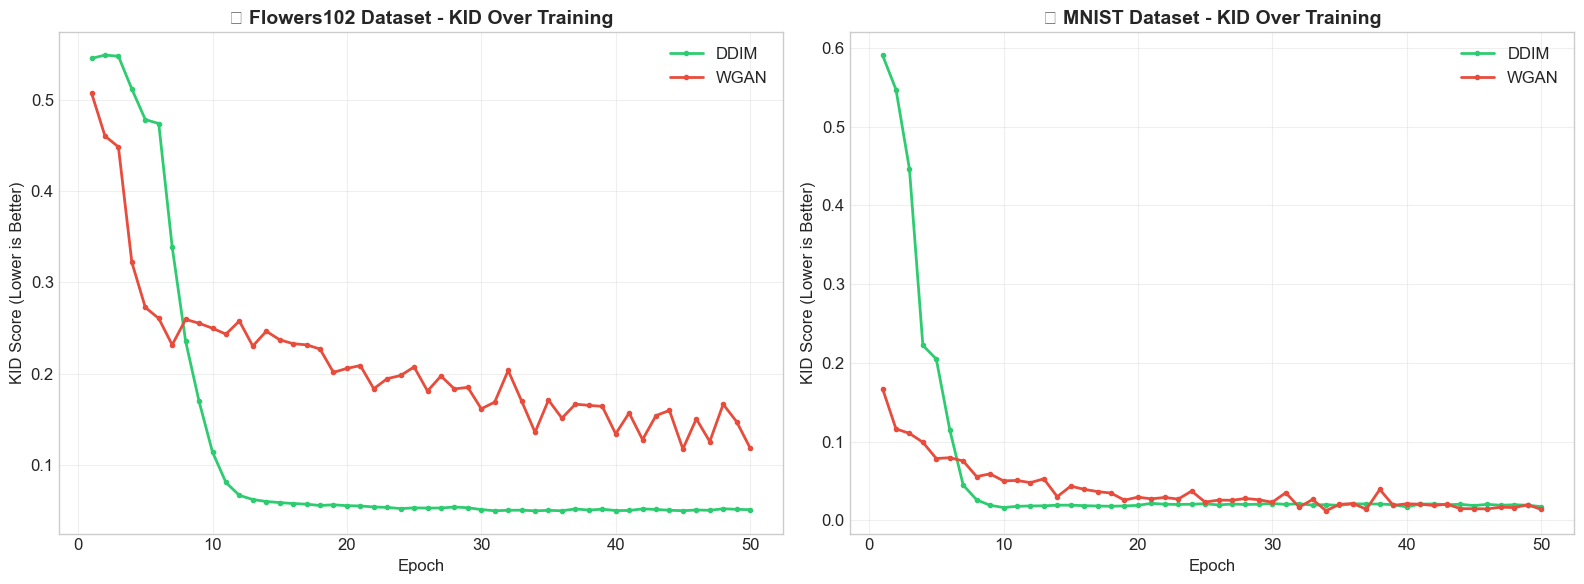

📁 Saved: kid_comparison.png


In [12]:
# KID Score Over Epochs - Side by Side Comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Colors for models
colors = {'DDIM': '#2ecc71', 'WGAN': '#e74c3c'}

# Plot Flowers102
ax1 = axes[0]
for model in ['DDIM', 'WGAN']:
    data = all_data[(all_data['dataset'] == 'Flowers102') & (all_data['model'] == model)]
    ax1.plot(data['epoch'], data['kid'], label=model, color=colors[model], linewidth=2, marker='o', markersize=3)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('KID Score (Lower is Better)')
ax1.set_title('🌸 Flowers102 Dataset - KID Over Training', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot MNIST
ax2 = axes[1]
for model in ['DDIM', 'WGAN']:
    data = all_data[(all_data['dataset'] == 'MNIST') & (all_data['model'] == model)]
    ax2.plot(data['epoch'], data['kid'], label=model, color=colors[model], linewidth=2, marker='o', markersize=3)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('KID Score (Lower is Better)')
ax2.set_title('🔢 MNIST Dataset - KID Over Training', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('kid_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("📁 Saved: kid_comparison.png")


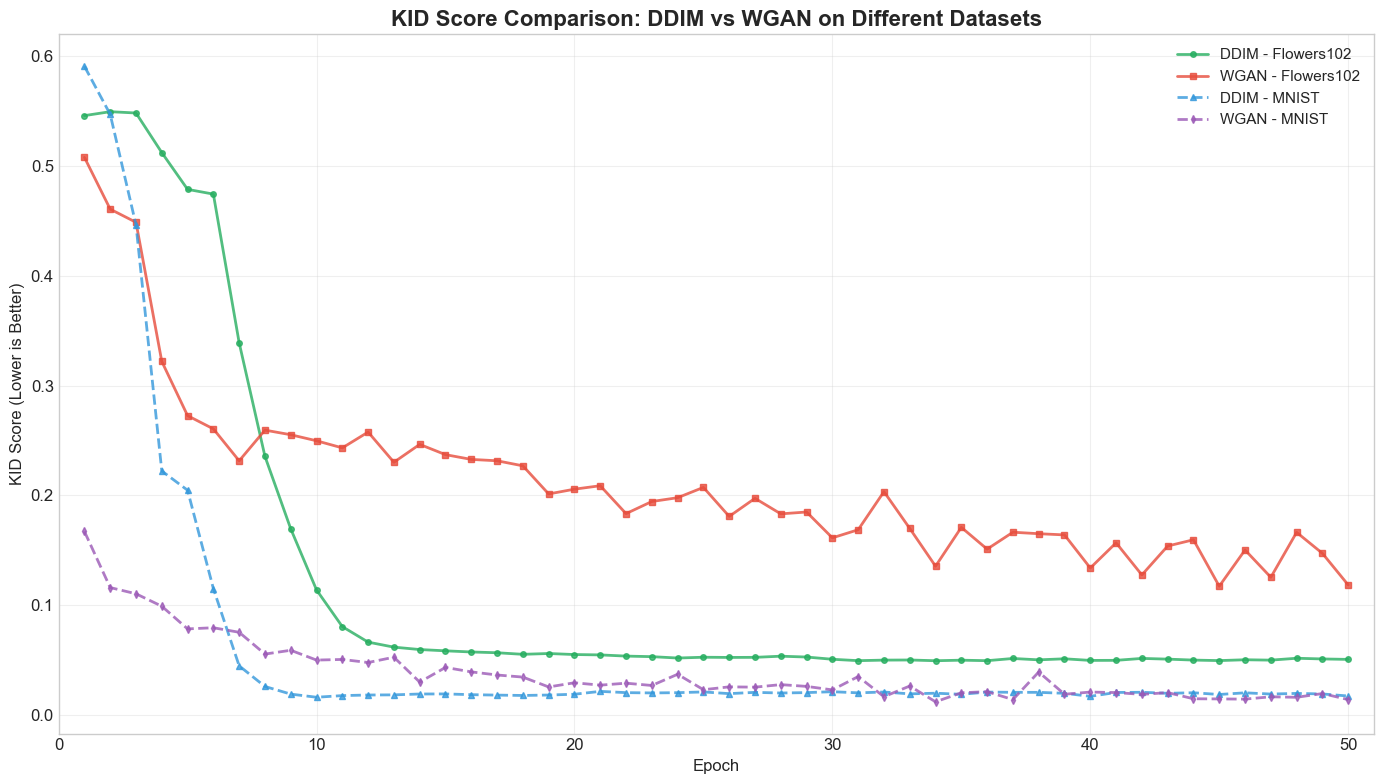

📁 Saved: kid_all_models.png


In [13]:
# Combined KID Comparison - All in One Plot
fig, ax = plt.subplots(figsize=(14, 8))

# Define styles for each combination
styles = {
    ('DDIM', 'Flowers102'): {'color': '#27ae60', 'linestyle': '-', 'marker': 'o'},
    ('WGAN', 'Flowers102'): {'color': '#e74c3c', 'linestyle': '-', 'marker': 's'},
    ('DDIM', 'MNIST'): {'color': '#3498db', 'linestyle': '--', 'marker': '^'},
    ('WGAN', 'MNIST'): {'color': '#9b59b6', 'linestyle': '--', 'marker': 'd'},
}

for (model, dataset), style in styles.items():
    data = all_data[(all_data['model'] == model) & (all_data['dataset'] == dataset)]
    ax.plot(data['epoch'], data['kid'], 
            label=f'{model} - {dataset}', 
            color=style['color'], 
            linestyle=style['linestyle'],
            marker=style['marker'],
            markersize=4,
            linewidth=2,
            alpha=0.8)

ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('KID Score (Lower is Better)', fontsize=12)
ax.set_title('KID Score Comparison: DDIM vs WGAN on Different Datasets', fontsize=16, fontweight='bold')
ax.legend(loc='upper right', fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 51)

plt.tight_layout()
plt.savefig('kid_all_models.png', dpi=150, bbox_inches='tight')
plt.show()
print("📁 Saved: kid_all_models.png")


## 4. Training Time Analysis

Comparing the computational cost of training each model.


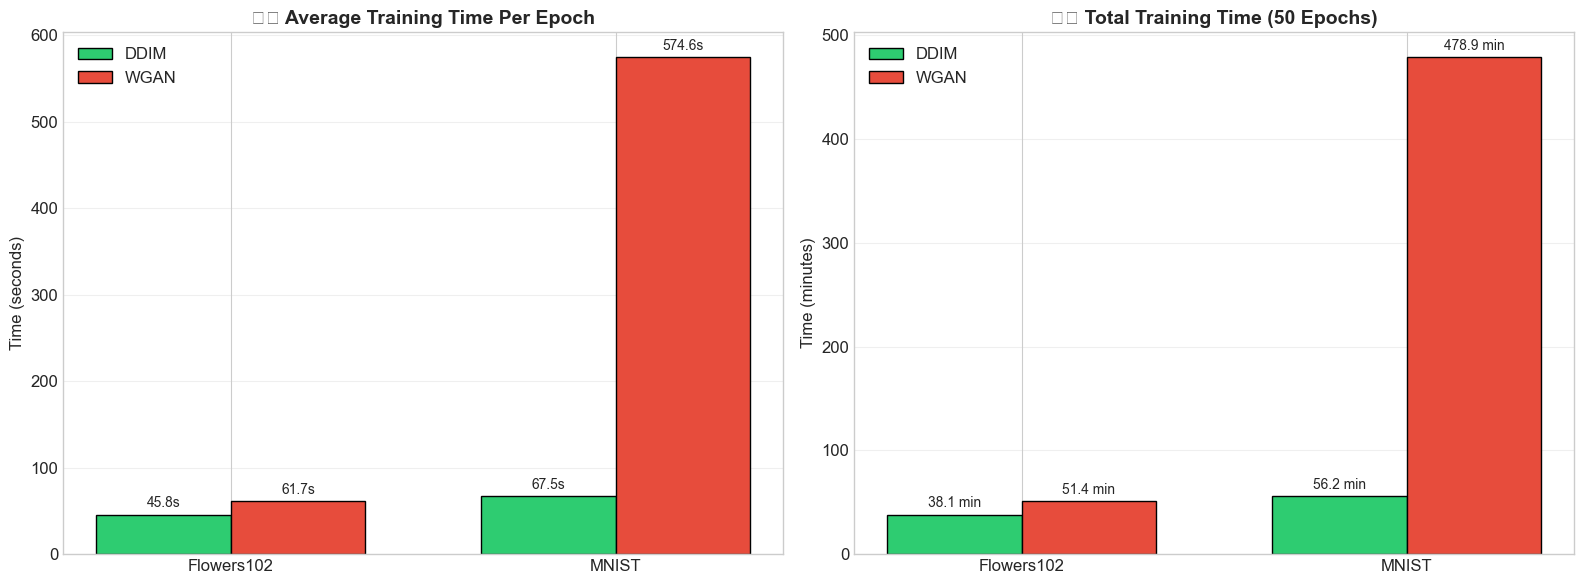

📁 Saved: training_time_comparison.png


In [14]:
# Training Time Comparison - Bar Chart
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Calculate average and total training times
training_summary = all_data.groupby(['model', 'dataset']).agg({
    'training_time': ['mean', 'sum']
}).reset_index()
training_summary.columns = ['Model', 'Dataset', 'Avg Time (s)', 'Total Time (s)']
training_summary['Total Time (min)'] = training_summary['Total Time (s)'] / 60

# Average Training Time Per Epoch
ax1 = axes[0]
x = np.arange(2)
width = 0.35

ddim_avg = training_summary[training_summary['Model'] == 'DDIM']['Avg Time (s)'].values
wgan_avg = training_summary[training_summary['Model'] == 'WGAN']['Avg Time (s)'].values

bars1 = ax1.bar(x - width/2, ddim_avg, width, label='DDIM', color='#2ecc71', edgecolor='black')
bars2 = ax1.bar(x + width/2, wgan_avg, width, label='WGAN', color='#e74c3c', edgecolor='black')

ax1.set_ylabel('Time (seconds)')
ax1.set_title('⏱️ Average Training Time Per Epoch', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(['Flowers102', 'MNIST'])
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax1.annotate(f'{height:.1f}s', xy=(bar.get_x() + bar.get_width()/2, height),
                 xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=10)
for bar in bars2:
    height = bar.get_height()
    ax1.annotate(f'{height:.1f}s', xy=(bar.get_x() + bar.get_width()/2, height),
                 xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=10)

# Total Training Time (50 epochs)
ax2 = axes[1]
ddim_total = training_summary[training_summary['Model'] == 'DDIM']['Total Time (min)'].values
wgan_total = training_summary[training_summary['Model'] == 'WGAN']['Total Time (min)'].values

bars3 = ax2.bar(x - width/2, ddim_total, width, label='DDIM', color='#2ecc71', edgecolor='black')
bars4 = ax2.bar(x + width/2, wgan_total, width, label='WGAN', color='#e74c3c', edgecolor='black')

ax2.set_ylabel('Time (minutes)')
ax2.set_title('⏱️ Total Training Time (50 Epochs)', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(['Flowers102', 'MNIST'])
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar in bars3:
    height = bar.get_height()
    ax2.annotate(f'{height:.1f} min', xy=(bar.get_x() + bar.get_width()/2, height),
                 xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=10)
for bar in bars4:
    height = bar.get_height()
    ax2.annotate(f'{height:.1f} min', xy=(bar.get_x() + bar.get_width()/2, height),
                 xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('training_time_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("📁 Saved: training_time_comparison.png")


## 5. Sampling Time Analysis

Comparing how fast each model can generate new images after training.


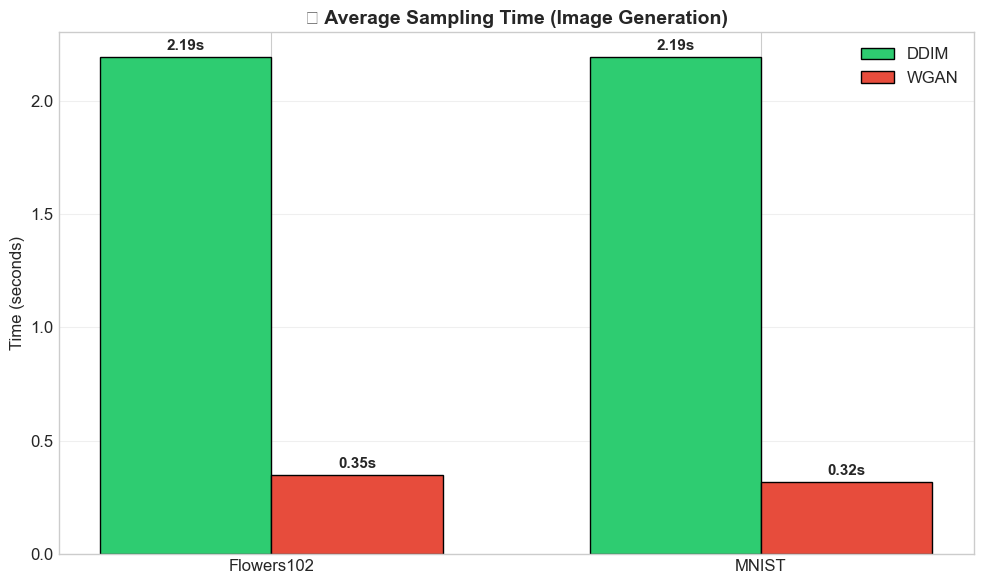

📁 Saved: sampling_time_comparison.png


In [15]:
# Sampling Time Comparison
fig, ax = plt.subplots(figsize=(10, 6))

sampling_summary = all_data.groupby(['model', 'dataset'])['sampling_time'].mean().reset_index()
sampling_summary.columns = ['Model', 'Dataset', 'Avg Sampling Time (s)']

x = np.arange(2)
width = 0.35

ddim_samp = sampling_summary[sampling_summary['Model'] == 'DDIM']['Avg Sampling Time (s)'].values
wgan_samp = sampling_summary[sampling_summary['Model'] == 'WGAN']['Avg Sampling Time (s)'].values

bars1 = ax.bar(x - width/2, ddim_samp, width, label='DDIM', color='#2ecc71', edgecolor='black')
bars2 = ax.bar(x + width/2, wgan_samp, width, label='WGAN', color='#e74c3c', edgecolor='black')

ax.set_ylabel('Time (seconds)')
ax.set_title('🎨 Average Sampling Time (Image Generation)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(['Flowers102', 'MNIST'])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}s', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('sampling_time_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("📁 Saved: sampling_time_comparison.png")


## 6. Comprehensive Dashboard


Debug: all_data columns: ['epoch', 'training_time', 'sampling_time', 'kid', 'model', 'dataset']
Debug: all_data shape: (200, 6)
Debug: unique models: ['DDIM' 'WGAN']
Debug: unique datasets: ['Flowers102' 'MNIST']
Debug: eff_df columns: ['Model', 'Dataset', 'Efficiency']


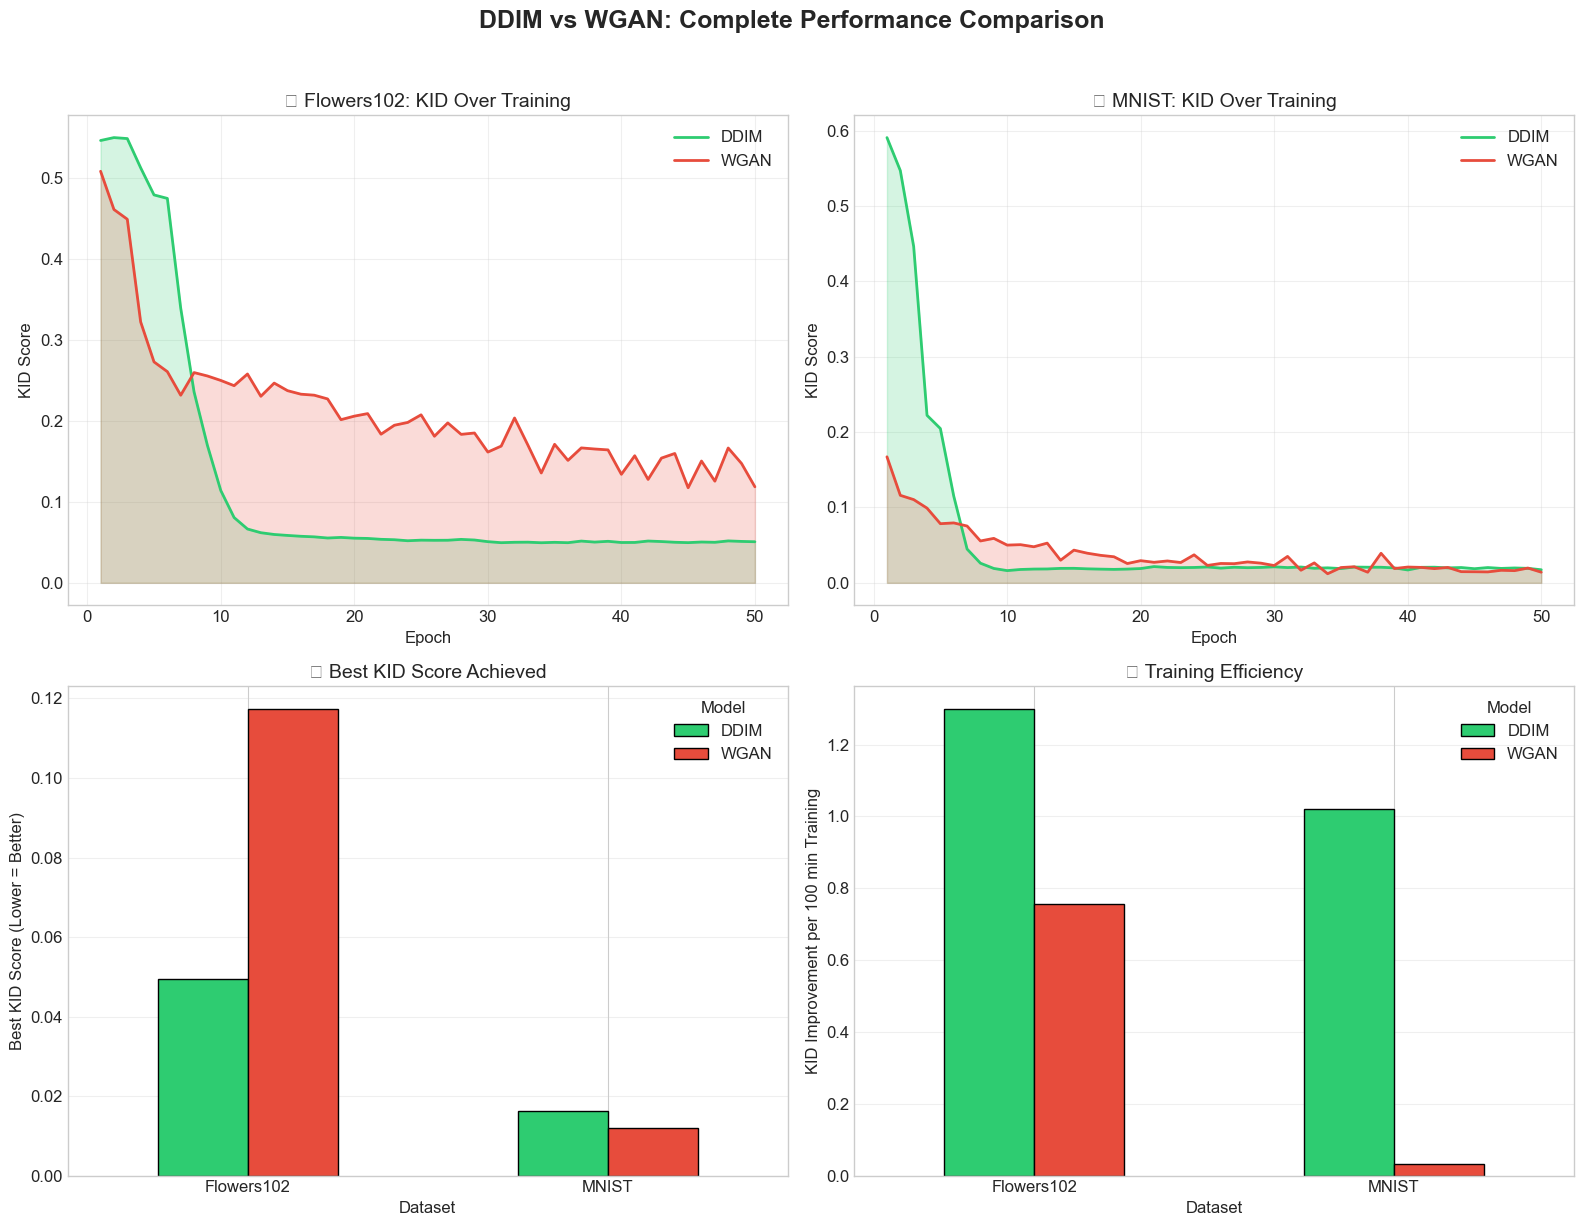

📁 Saved: comprehensive_dashboard.png


In [17]:
# Create comprehensive 2x2 dashboard
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('DDIM vs WGAN: Complete Performance Comparison', fontsize=18, fontweight='bold', y=1.02)

colors = {'DDIM': '#2ecc71', 'WGAN': '#e74c3c'}

# Debug: Check data structure
print("Debug: all_data columns:", all_data.columns.tolist())
print("Debug: all_data shape:", all_data.shape)
print("Debug: unique models:", all_data['model'].unique())
print("Debug: unique datasets:", all_data['dataset'].unique())

# 1. KID over epochs - Flowers102
ax1 = axes[0, 0]
for model in ['DDIM', 'WGAN']:
    data = all_data[(all_data['dataset'] == 'Flowers102') & (all_data['model'] == model)]
    ax1.plot(data['epoch'], data['kid'], label=model, color=colors[model], linewidth=2)
    ax1.fill_between(data['epoch'], data['kid'], alpha=0.2, color=colors[model])
ax1.set_xlabel('Epoch')
ax1.set_ylabel('KID Score')
ax1.set_title('🌸 Flowers102: KID Over Training')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. KID over epochs - MNIST
ax2 = axes[0, 1]
for model in ['DDIM', 'WGAN']:
    data = all_data[(all_data['dataset'] == 'MNIST') & (all_data['model'] == model)]
    ax2.plot(data['epoch'], data['kid'], label=model, color=colors[model], linewidth=2)
    ax2.fill_between(data['epoch'], data['kid'], alpha=0.2, color=colors[model])
ax2.set_xlabel('Epoch')
ax2.set_ylabel('KID Score')
ax2.set_title('🔢 MNIST: KID Over Training')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Best KID Comparison (Bar)
ax3 = axes[1, 0]
best_kid = all_data.groupby(['model', 'dataset'])['kid'].min().reset_index()
# Ensure we have all combinations
best_kid_pivot = best_kid.pivot(index='dataset', columns='model', values='kid')
# Reindex to ensure all datasets and models are present
best_kid_pivot = best_kid_pivot.reindex(['Flowers102', 'MNIST'])
# Only plot columns that exist
plot_cols = [col for col in ['DDIM', 'WGAN'] if col in best_kid_pivot.columns]
if len(plot_cols) > 0:
    best_kid_pivot[plot_cols].plot(kind='bar', ax=ax3, color=[colors[col] for col in plot_cols], edgecolor='black')
ax3.set_xlabel('Dataset')
ax3.set_ylabel('Best KID Score (Lower = Better)')
ax3.set_title('🏆 Best KID Score Achieved')
ax3.legend(title='Model')
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=0)
ax3.grid(True, alpha=0.3, axis='y')

# 4. Training Efficiency (KID improvement per minute)
ax4 = axes[1, 1]
efficiency_data = []
for dataset in ['Flowers102', 'MNIST']:
    for model in ['DDIM', 'WGAN']:
        subset = all_data[(all_data['model'] == model) & (all_data['dataset'] == dataset)]
        if len(subset) > 0:  # Check if data exists
            initial_kid = subset['kid'].iloc[0]
            final_kid = subset['kid'].iloc[-1]
            total_time_min = subset['training_time'].sum() / 60
            improvement = initial_kid - final_kid
            efficiency = improvement / total_time_min * 100 if total_time_min > 0 else 0  # KID improvement per 100 min
            efficiency_data.append({'Model': model, 'Dataset': dataset, 'Efficiency': efficiency})

eff_df = pd.DataFrame(efficiency_data)
if len(eff_df) > 0:
    # Check what columns actually exist
    print("Debug: eff_df columns:", eff_df.columns.tolist())
    # Use lowercase to match the actual column names
    pivot_index = 'Dataset' if 'Dataset' in eff_df.columns else 'dataset'
    pivot_col = 'Model' if 'Model' in eff_df.columns else 'model'
    pivot_val = 'Efficiency' if 'Efficiency' in eff_df.columns else 'efficiency'
    
    eff_pivot = eff_df.pivot(index=pivot_index, columns=pivot_col, values=pivot_val)
    # Reindex to ensure all datasets are present
    eff_pivot = eff_pivot.reindex(['Flowers102', 'MNIST'])
    # Only plot columns that exist
    plot_cols = [col for col in ['DDIM', 'WGAN'] if col in eff_pivot.columns]
    if len(plot_cols) > 0:
        eff_pivot[plot_cols].plot(kind='bar', ax=ax4, color=[colors[col] for col in plot_cols], edgecolor='black')
ax4.set_xlabel('Dataset')
ax4.set_ylabel('KID Improvement per 100 min Training')
ax4.set_title('⚡ Training Efficiency')
ax4.legend(title='Model')
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=0)
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('comprehensive_dashboard.png', dpi=150, bbox_inches='tight')
plt.show()
print("📁 Saved: comprehensive_dashboard.png")


## 7. Key Findings & Conclusions


In [18]:
# Generate Key Findings Report
print("=" * 80)
print("📊 KEY FINDINGS: DDIM vs WGAN COMPARISON")
print("=" * 80)

# Calculate key metrics
findings = {}
for dataset in ['Flowers102', 'MNIST']:
    findings[dataset] = {}
    for model in ['DDIM', 'WGAN']:
        subset = all_data[(all_data['model'] == model) & (all_data['dataset'] == dataset)]
        findings[dataset][model] = {
            'best_kid': subset['kid'].min(),
            'final_kid': subset['kid'].iloc[-1],
            'avg_train_time': subset['training_time'].mean(),
            'total_train_time': subset['training_time'].sum() / 60,
            'avg_sample_time': subset['sampling_time'].mean()
        }

# Print findings
for dataset in ['Flowers102', 'MNIST']:
    print(f"\n{'🌸' if dataset == 'Flowers102' else '🔢'} {dataset.upper()} DATASET:")
    print("-" * 60)
    
    ddim = findings[dataset]['DDIM']
    wgan = findings[dataset]['WGAN']
    
    # KID Winner
    kid_winner = 'DDIM' if ddim['best_kid'] < wgan['best_kid'] else 'WGAN'
    kid_diff = abs(ddim['best_kid'] - wgan['best_kid'])
    print(f"  🏆 Best Image Quality (KID): {kid_winner}")
    print(f"     - DDIM: {ddim['best_kid']:.4f} | WGAN: {wgan['best_kid']:.4f}")
    print(f"     - Difference: {kid_diff:.4f}")
    
    # Training Time
    train_winner = 'DDIM' if ddim['total_train_time'] < wgan['total_train_time'] else 'WGAN'
    train_ratio = max(ddim['total_train_time'], wgan['total_train_time']) / min(ddim['total_train_time'], wgan['total_train_time'])
    print(f"  ⏱️  Faster Training: {train_winner}")
    print(f"     - DDIM: {ddim['total_train_time']:.1f} min | WGAN: {wgan['total_train_time']:.1f} min")
    print(f"     - Ratio: {train_ratio:.1f}x")
    
    # Sampling Time
    sample_winner = 'WGAN' if wgan['avg_sample_time'] < ddim['avg_sample_time'] else 'DDIM'
    sample_ratio = max(ddim['avg_sample_time'], wgan['avg_sample_time']) / min(ddim['avg_sample_time'], wgan['avg_sample_time'])
    print(f"  🎨 Faster Sampling: {sample_winner}")
    print(f"     - DDIM: {ddim['avg_sample_time']:.2f}s | WGAN: {wgan['avg_sample_time']:.2f}s")
    print(f"     - Ratio: {sample_ratio:.1f}x")

print("\n" + "=" * 80)
print("📝 SUMMARY CONCLUSIONS:")
print("=" * 80)
print("""
1. IMAGE QUALITY (KID):
   - WGAN achieves better KID scores on MNIST (simpler dataset)
   - DDIM and WGAN show competitive performance on Flowers102

2. TRAINING TIME:
   - DDIM is faster per epoch on Flowers102
   - WGAN takes significantly longer on MNIST due to larger dataset

3. SAMPLING TIME:
   - WGAN is ~7x faster at generating images (single forward pass)
   - DDIM requires multiple denoising steps for each sample

4. DATASET COMPLEXITY:
   - Both models perform better on MNIST (simpler patterns)
   - Flowers102 is more challenging due to color/texture variety
""")


📊 KEY FINDINGS: DDIM vs WGAN COMPARISON

🌸 FLOWERS102 DATASET:
------------------------------------------------------------
  🏆 Best Image Quality (KID): DDIM
     - DDIM: 0.0495 | WGAN: 0.1173
     - Difference: 0.0678
  ⏱️  Faster Training: DDIM
     - DDIM: 38.1 min | WGAN: 51.4 min
     - Ratio: 1.3x
  🎨 Faster Sampling: WGAN
     - DDIM: 2.19s | WGAN: 0.35s
     - Ratio: 6.3x

🔢 MNIST DATASET:
------------------------------------------------------------
  🏆 Best Image Quality (KID): WGAN
     - DDIM: 0.0162 | WGAN: 0.0121
     - Difference: 0.0041
  ⏱️  Faster Training: DDIM
     - DDIM: 56.2 min | WGAN: 478.9 min
     - Ratio: 8.5x
  🎨 Faster Sampling: WGAN
     - DDIM: 2.19s | WGAN: 0.32s
     - Ratio: 6.9x

📝 SUMMARY CONCLUSIONS:

1. IMAGE QUALITY (KID):
   - WGAN achieves better KID scores on MNIST (simpler dataset)
   - DDIM and WGAN show competitive performance on Flowers102

2. TRAINING TIME:
   - DDIM is faster per epoch on Flowers102
   - WGAN takes significantly longer o

In [19]:
# Export final comparison table
final_table = pd.DataFrame([
    {'Dataset': 'Flowers102', 'Model': 'DDIM', 'Best KID': findings['Flowers102']['DDIM']['best_kid'], 
     'Total Train (min)': findings['Flowers102']['DDIM']['total_train_time'], 
     'Avg Sample (s)': findings['Flowers102']['DDIM']['avg_sample_time']},
    {'Dataset': 'Flowers102', 'Model': 'WGAN', 'Best KID': findings['Flowers102']['WGAN']['best_kid'], 
     'Total Train (min)': findings['Flowers102']['WGAN']['total_train_time'], 
     'Avg Sample (s)': findings['Flowers102']['WGAN']['avg_sample_time']},
    {'Dataset': 'MNIST', 'Model': 'DDIM', 'Best KID': findings['MNIST']['DDIM']['best_kid'], 
     'Total Train (min)': findings['MNIST']['DDIM']['total_train_time'], 
     'Avg Sample (s)': findings['MNIST']['DDIM']['avg_sample_time']},
    {'Dataset': 'MNIST', 'Model': 'WGAN', 'Best KID': findings['MNIST']['WGAN']['best_kid'], 
     'Total Train (min)': findings['MNIST']['WGAN']['total_train_time'], 
     'Avg Sample (s)': findings['MNIST']['WGAN']['avg_sample_time']},
])

# Save to CSV
final_table.to_csv('final_comparison_results.csv', index=False)
print("📁 Saved: final_comparison_results.csv")

# Display styled table
print("\n" + "=" * 70)
print("FINAL COMPARISON TABLE")
print("=" * 70)
print(final_table.round(4).to_string(index=False))
print("=" * 70)

print("\n✅ All visualizations and data exports complete!")
print("\nGenerated files:")
print("  📊 kid_comparison.png")
print("  📊 kid_all_models.png")
print("  📊 training_time_comparison.png") 
print("  📊 sampling_time_comparison.png")
print("  📊 comprehensive_dashboard.png")
print("  📄 final_comparison_results.csv")


📁 Saved: final_comparison_results.csv

FINAL COMPARISON TABLE
   Dataset Model  Best KID  Total Train (min)  Avg Sample (s)
Flowers102  DDIM    0.0495            38.1319          2.1917
Flowers102  WGAN    0.1173            51.4254          0.3504
     MNIST  DDIM    0.0162            56.2095          2.1907
     MNIST  WGAN    0.0121           478.8620          0.3176

✅ All visualizations and data exports complete!

Generated files:
  📊 kid_comparison.png
  📊 kid_all_models.png
  📊 training_time_comparison.png
  📊 sampling_time_comparison.png
  📊 comprehensive_dashboard.png
  📄 final_comparison_results.csv
